# Code for competition

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import shutil
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from PIL import Image
import re
import time

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
print(tf.config.list_physical_devices())

# Enable experimental feature of memory occupation growth control 
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for dev in physical_devices:
    tf.config.experimental.set_memory_growth(dev, True)

# Random seed for reproducibility
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.9.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Metadata

In [2]:
classes = ["Species1", "Species2", "Species3", "Species4", "Species5", "Species6", "Species7", "Species8"]
input_shape = (96, 96, 3)
input_size = input_shape[:-1]
inflation_coeff = 1.5

batch_size = 16
epochs = 400

### Prepare the environment

In [3]:
path = os.getcwd()
if not os.path.exists(path+'/training_data_final'):
    shutil.copytree('../input/training-data-final2/training_data_final', path + r'/training_data_final')

['competition_offline.ipynb', 'competition_online.ipynb', 'gab2_competition_online.ipynb', 'gab_2.ipynb', 'gab_2_weights.ipynb', 'gab_2_weights_final_online.ipynb', 'gab_2_weights_transf_improved.ipynb', 'gab_folder', 'models_tests.py', 'saturation_contrast_test.ipynb', 'simo_data_aug_model_evaluation.ipynb', 'simo_data_flow.ipynb', 'simo_data_preprocessing.ipynb', 'simo_model', 'tloa-efficientnetb2.ipynb', 'training', 'training_data_final', 'transfer-learning-online-augmentation.ipynb', 'validation']


In [4]:
train_split = 0.8

path = os.getcwd()
if not os.path.exists(path+'/training') and not os.path.exists(path+'/validation'):
    os.mkdir(path+'/training')
    os.mkdir(path+'/validation')

    # Destination path 
    dest_train = path + '/training'
    dest_valid = path + '/validation'

    # Source path
    source = path + '/training_data_final'

    # Create train and validation into the training and validation folders
    for folder in os.listdir(source):
        if not os.path.exists(dest_train + '/' + folder):
            os.mkdir(dest_train + '/' + folder)
        if not os.path.exists(dest_valid + '/' + folder):
            os.mkdir(dest_valid + '/' + folder)
    
        class_source = source + '/' + folder                                                   # Create path of the class
        files = os.listdir(class_source)                                                       # List of files for the class
        random.shuffle(files)                                                                  # Split is performed randomly
        
        # Create training set randomly
        for i in range(int(len(files) * train_split)):
            dest = shutil.copy(class_source+'/'+files[i], dest_train+'/'+folder+'/'+files[i])  # Copy an image in the training set
        
        # Create validation set randomly
        for j in range(i + 1, len(files)):
            dest = shutil.copy(class_source+'/'+files[j], dest_valid+'/'+folder+'/'+files[j])  # copy an image in the validation set

### Preprocessing function

Allows us to simply define a pipeline of preprocessing transformations

In [5]:
from tensorflow.keras.applications.efficientnet import preprocess_input

def preprocessing(image):
    #return tf.image.adjust_saturation(image, 3)
    return preprocess_input(image)
    #return image

### Prepare the training set for standardization

In [6]:
samples = []
targets = []

dest_train = os.getcwd() + '/training'

for folder in os.listdir(dest_train):
    dest_class = dest_train + '/' + folder
    i = int(re.sub("\D", "", folder)) - 1
    for img in os.listdir(dest_class):
        temp = Image.open(dest_class + '/' + img).convert('RGB')
        image = preprocessing(np.squeeze(np.expand_dims(temp, axis=0)))
        label = tfk.utils.to_categorical(i, len(classes))
        samples.append(image)
        targets.append(label)
X_train = np.array(samples)
y_train = np.array(targets, dtype=np.uint8)
del samples
del targets
print(X_train.shape, X_train.dtype, sep=", ")
print(y_train.shape, y_train.dtype, sep=", ")

# Compute the class weights in order to balance loss during training
y_numeric = []
for v in y_train:
    y_numeric.append(np.argmax(v))

labels = np.unique(np.fromiter([np.argmax(t) for t in y_train], np.int32))
    
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y_numeric)))
print(class_weights)

(2829, 96, 96, 3), uint8
(2829, 8), uint8
{0: 2.389358108108108, 1: 0.8320588235294117, 2: 0.8583131067961165, 3: 0.8667279411764706, 4: 0.8340212264150944, 5: 1.9978813559322033, 6: 0.8243006993006993, 7: 0.8709975369458128}


### Static augmentation (only on training set)

In [7]:
static_aug = False
balanced = False

path = os.getcwd()
if static_aug and not os.path.exists(path+'/training_aug'):
    old_train = os.getcwd() + '/training'
    dest_train = os.getcwd() + '/training_aug'
    shutil.copytree(old_train, dest_train)

    desired_amount = int(537 * train_split)

    static_gen = ImageDataGenerator()

    for folder in os.listdir(dest_train):
        dest_path = dest_train + '/' + folder
        label = int(re.sub("\D", "", folder)) - 1

        if balanced:
            class_expansion = [3, 3, 3, 3, 3, 3, 3, 3]
        else:
            class_expansion = [6, 1, 1, 1, 1, 4, 1, 4]
        to_produce = (class_expansion[label] * desired_amount) - len(os.listdir(dest_path))
        
        static_gen_data = static_gen.flow_from_directory(dest_train,
                                                        batch_size=1,
                                                        target_size=input_size,
                                                        classes=[folder],
                                                        class_mode='categorical',      # Targets are directly converted into one-hot vectors
                                                        shuffle=False,
                                                        seed=seed) 

        print(f'Computing {to_produce} augmented images for target "{folder}"')
        os.chdir(dest_path)
        for i in range(0, to_produce):
            Image.fromarray(np.squeeze(next(static_gen_data)[0]).astype(np.uint8)).save(f'aug{i:05}.jpg')
        os.chdir('../')

    os.chdir('../')
    print('\n' + os.getcwd())

### Online augmentation
Lets create the generators we'll need...

In [8]:
shift = 30
train_data_gen = ImageDataGenerator(rotation_range=90,
                                    width_shift_range=shift,
                                    height_shift_range=shift,
                                    horizontal_flip=True,
                                    brightness_range=(0.8, 1.1),
                                    #channel_shift_range=150,
                                    zoom_range=[0.8, 1.5],
                                    #shear_range=10,
                                    fill_mode='reflect',
                                    preprocessing_function=preprocessing
                                    #featurewise_std_normalization=True,
                                    #featurewise_center=True 
                                    #rescale=1./255
                                    )

valid_data_gen = ImageDataGenerator(preprocessing_function=preprocessing
                                    #featurewise_std_normalization=True,
                                    #featurewise_center=True 
                                    #rescale=1./255
                                    )

# Fit the standardization values
#train_data_gen.fit(X_train)
#valid_data_gen.fit(X_train)

... using flow_from_directory

In [9]:
# Setting right paths
path = os.getcwd()
if static_aug:
    training_dir = path + '/training_aug'
else:
    training_dir = path + '/training'
validation_dir = path + '/validation'

# Training
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               batch_size=batch_size,
                                               target_size=input_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=seed)  

# Validation
valid_gen = valid_data_gen.flow_from_directory(validation_dir,
                                               batch_size=batch_size, 
                                               target_size=input_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=seed)

# Disable AutoShard
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF

# Create Datasets objects
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float16, tf.uint8),
                                               output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None, len(classes)]))

train_dataset = train_dataset.with_options(options)
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float16, tf.uint8),
                                               output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None, len(classes)]))

valid_dataset = valid_dataset.with_options(options)
valid_dataset = valid_dataset.repeat()

Found 2829 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


### Prepare the validation set for evaluation purposes

In [10]:
samples = []
targets = []

# Populate values needed for standardization
#mean = train_data_gen.mean
#std = train_data_gen.std
#print(mean, std)

dest_valid = os.getcwd() + '/validation'

for folder in os.listdir(dest_valid):
    dest_class = dest_valid + '/' + folder
    i = int(re.sub("\D", "", folder)) - 1
    for img in os.listdir(dest_class):
        temp = Image.open(dest_class + '/' + img).convert('RGB')
        #image = preprocessing((np.squeeze(np.expand_dims(temp, axis=0)) - mean) / std)  # IF WE USE STANDARDIZATION
        image = preprocessing(np.squeeze(np.expand_dims(temp, axis=0)))
        label = tfk.utils.to_categorical(i, len(classes))
        samples.append(image)
        targets.append(label)

X_val = np.array(samples, dtype=np.float16)
y_val = np.array(targets, dtype=np.uint8)
del samples
del targets
print(X_val.shape, X_val.dtype, sep=", ")
print(y_val.shape, y_val.dtype, sep=", ")

(713, 96, 96, 3), float16
(713, 8), uint8


### Models definition functions

In [11]:
def build_tl_model(input_shape):
    tf.random.set_seed(seed)
    
    inflated_dim0 = int(inflation_coeff * input_shape[0])
    inflated_dim1 = int(inflation_coeff * input_shape[1])
    inflated_shape = (inflated_dim0, inflated_dim1, 3)

    # Load the supernet
    supernet = tfk.applications.EfficientNetB2(include_top=False,
                                               weights="imagenet",
                                               input_shape=inflated_shape)
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    x = tfkl.Resizing(inflated_dim0, inflated_dim1, interpolation="bicubic", name='resizing')(input_layer)
    
    x = supernet(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    #x = tfkl.Flatten(name='flatten')(x)

    x = tfkl.Dropout(0.5, seed=seed, name='dropout')(x)
    
    output_layer = tfkl.Dense(
        units = len(classes), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'tl_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(5e-4), metrics='accuracy')

    # Return the model
    return model

### Build the model

In [12]:
model = build_tl_model(input_shape)

model.summary()

Model: "tl_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 144, 144, 3)       0         
                                                                 
 efficientnetb2 (Functional)  (None, 5, 5, 1408)       7768569   
                                                                 
 gap (GlobalAveragePooling2D  (None, 1408)             0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 output_layer (Dense)        (None, 8)                 11272     
                                                          

### Train the model

In [13]:
train_mul = 1

'''
high_period = 5
medium_period = 10
low_period = 5

high_lr = 5e-4  
medium_lr = 1e-4
low_lr = 2e-5

def scheduler(epoch, lr):
    global medium_lr, high_lr

    #convergence factor to shrink high and medium values onto low_lr over time
    tot_period = high_period + medium_period + low_period + medium_period
    if epoch % (tot_period) == (tot_period - 1):
        high_lr = max(high_lr * tf.math.exp(-0.1), low_lr)
        medium_lr = max(medium_lr * tf.math.exp(-0.1), low_lr)

    if epoch % (tot_period) < high_period:
        return high_lr
    elif epoch % (tot_period) < high_period + medium_period:
        return medium_lr    
    elif epoch % (tot_period) < high_period + medium_period + low_period:
        return low_lr    
    return medium_lr
'''

decay_rate = 5  # patience should be set: changes_to_see * decay_rate + 1
min_lr = 2e-5

def scheduler(epoch, lr):
    if epoch % decay_rate == (decay_rate - 1):
        return max(lr * tf.math.exp(-0.1), min_lr)
    return lr

start = time.time()

class ElapsedTimeCallback(tfk.callbacks.Callback):
    def on_test_end(self, epoch, logs=None):
        el = time.time() - start
        print(f'\nElapsed time: {int(el // 60)} minutes {(el % 60):.3f} seconds')

history = model.fit(x=train_dataset,
                    epochs=epochs,                                     # Only indicative since we set "repeat" in training and validation datasets
                    steps_per_epoch=int(len(train_gen) * train_mul),
                    validation_data=valid_dataset,
                    validation_steps=len(valid_gen),
                    class_weight=class_weights,
                    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=21, restore_best_weights=True),
                                 tfk.callbacks.LearningRateScheduler(scheduler),
                                 ElapsedTimeCallback()]
).history

Epoch 1/400
177/177 [==============================] - ETA: 0s - loss: 1.4009 - accuracy: 0.4839
Elapsed time: 2 minutes 28.203 seconds
177/177 [==============================] - 149s 688ms/step - loss: 1.4009 - accuracy: 0.4839 - val_loss: 1.0925 - val_accuracy: 0.5975 - lr: 5.0000e-04
Epoch 2/400
177/177 [==============================] - ETA: 0s - loss: 0.9955 - accuracy: 0.6554
Elapsed time: 4 minutes 26.557 seconds
177/177 [==============================] - 118s 667ms/step - loss: 0.9955 - accuracy: 0.6554 - val_loss: 0.9057 - val_accuracy: 0.6844 - lr: 5.0000e-04
Epoch 3/400
177/177 [==============================] - ETA: 0s - loss: 0.8431 - accuracy: 0.7048
Elapsed time: 6 minutes 27.947 seconds
177/177 [==============================] - 121s 686ms/step - loss: 0.8431 - accuracy: 0.7048 - val_loss: 1.0112 - val_accuracy: 0.7097 - lr: 5.0000e-04
Epoch 4/400
177/177 [==============================] - ETA: 0s - loss: 0.7192 - accuracy: 0.7625
Elapsed time: 8 minutes 33.764 seconds


### Plot training results

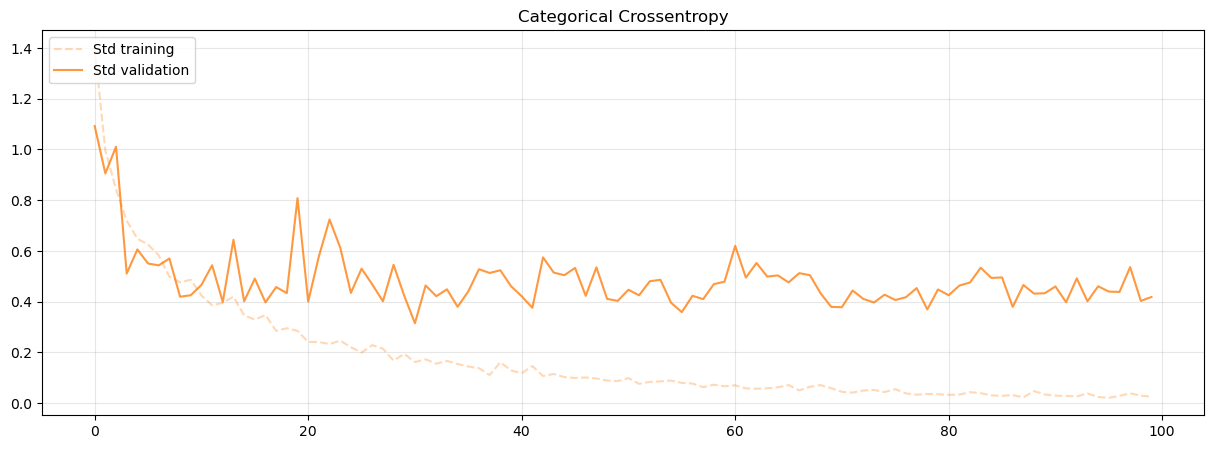

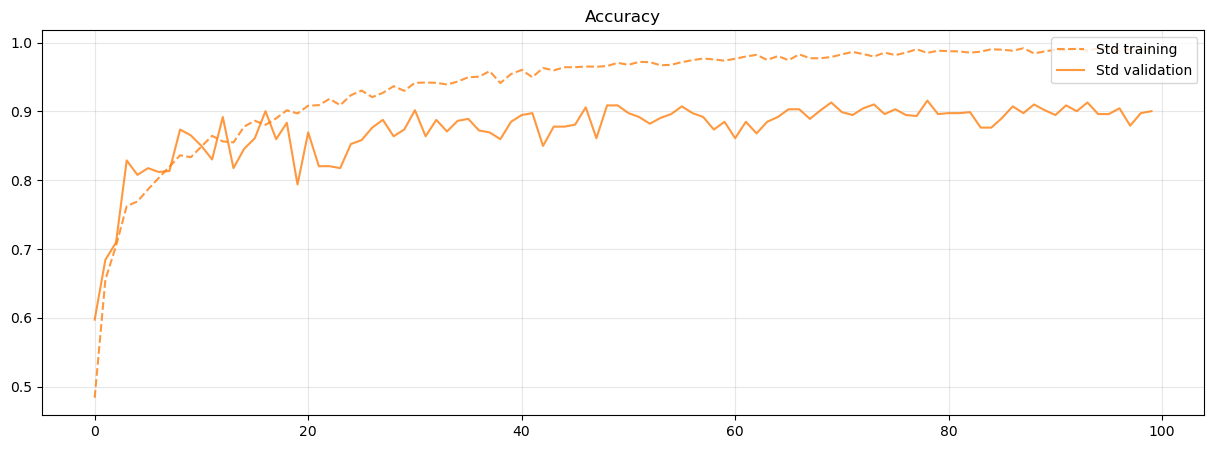

In [14]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

del history

### Plot the confusion matrix (evaluated on the validation set)

23/23 [==============================] - 12s 246ms/step
Accuracy: 0.9158
Precision: 0.9136
Recall: 0.8669
F1: [0.5763 0.8957 0.9714 0.9384 0.9677 0.8608 0.9439 0.8932]


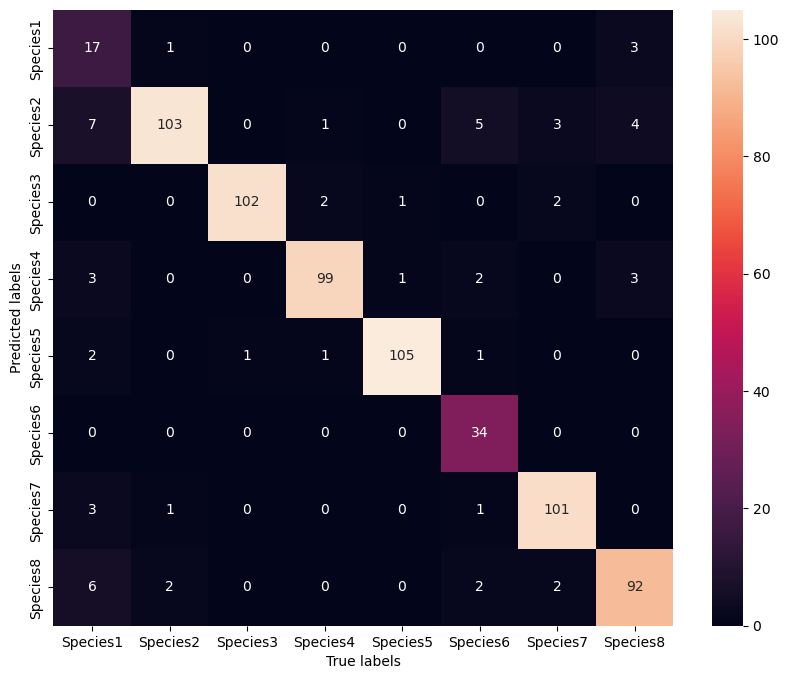

In [15]:
predictions = model.predict(X_val)
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average=None)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=classes, yticklabels=classes, annot=True, fmt="d")
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Save the model

In [16]:
model.save('best_model', include_optimizer=False)

del model

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


### Improve the classifier module of the previously trained supernet

In [17]:
def build_classifier_model(input_shape):
    tf.random.set_seed(seed)
    
    inflated_dim0 = int(inflation_coeff * input_shape[0])
    inflated_dim1 = int(inflation_coeff * input_shape[1])
    inflated_shape = (inflated_dim0, inflated_dim1, 3)

    # Load the supernet
    supernet = tfk.applications.EfficientNetB2(include_top=False,
                                         input_shape=inflated_shape)

    # Recover previous weights
    supernet.set_weights(tfk.models.load_model('best_model').get_layer('efficientnetb2').get_weights())
    
    # Use the supernet only as feature extractor
    supernet.trainable = False  # "True" for fine tuning
    for i, layer in enumerate(supernet.layers[:-25]):
      layer.trainable = False
      #print(i, layer.name, layer.trainable)
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    x = tfkl.Resizing(inflated_dim0, inflated_dim1, interpolation="bicubic", name='resizing')(input_layer)
    
    x = supernet(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    
    x_gap = x

    x = tfkl.Dense(
        units = 1408,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'classifier1')(x)
    
    x = tfkl.Dense(
        units = 1408,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'classifier2')(x)
    
    x = tfkl.Dropout(0.5, seed=seed, name='dropout')(x)

    # Skip connection
    x = tfkl.Add(name='adder')([x_gap, x])
    
    output_layer = tfkl.Dense(
                   units = len(classes), 
                   activation = 'softmax', 
                   kernel_initializer = tfk.initializers.GlorotUniform(seed),
                   name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'classifier_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [18]:
classifier_model = build_classifier_model(input_shape)

classifier_model.summary()

Model: "classifier_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 resizing (Resizing)            (None, 144, 144, 3)  0           ['input_layer[0][0]']            
                                                                                                  
 efficientnetb2 (Functional)    (None, 5, 5, 1408)   7768569     ['resizing[0][0]']               
                                                                                                  
 gap (GlobalAveragePooling2D)   (None, 1408)         0           ['efficientnetb2[0][0]']         
                                                                                   

In [19]:
train_mul = 1

start = time.time()

classifier_history = classifier_model.fit(x=train_dataset,
                                          epochs=epochs,                                  
                                          steps_per_epoch=int(len(train_gen) * train_mul),
                                          validation_data=valid_dataset,
                                          validation_steps=len(valid_gen),
                                          class_weight=class_weights,
                                          callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=26, restore_best_weights=True),
                                                       tfk.callbacks.LearningRateScheduler(scheduler),
                                                       ElapsedTimeCallback()]
).history

Epoch 1/400
 14/177 [=>............................] - ETA: 27s - loss: 0.4790 - accuracy: 0.8571

KeyboardInterrupt: 

### Plot training results

In [ ]:
history = classifier_history

plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

del history
del classifier_history

### Plot the confusion matrix (evaluated on the validation set)

In [ ]:
predictions = classifier_model.predict(X_val)
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average=None)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=classes, yticklabels=classes, annot=True, fmt="d")
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Save the model

In [ ]:
classifier_model.save('best_model_improved', include_optimizer=False)

del classifier_model